<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/main/VELC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch import distributions
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
import os
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from torch.nn.parameter import Parameter
import math
from torch.nn import functional as F

In [ ]:

#Heartbeat data - getting good results
data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TRAIN', delimiter=',')
data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TEST', delimiter=',')[:-1]

#Gun motion data- very bad results could be due to low amount of data
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TEST.txt')

#Modestrain data- quite good results
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TEST.txt')


In [ ]:
data_test_val.shape

(4499, 141)

In [ ]:
data = np.concatenate((data_train, data_test_val), axis=0)


In [ ]:
data

array([[ 2.        ,  0.39814982,  0.50392146, ...,  0.21030731,
         0.25998274,  0.28884552],
       [ 2.        , -1.094367  , -1.2513069 , ...,  0.17415317,
         0.28896389,  0.36294778],
       [ 1.        ,  0.08169988,  0.05757971, ...,  0.12222389,
         0.05352738,  0.02381132],
       ...,
       [ 2.        , -0.1283685 ,  0.02047697, ..., -0.11498284,
        -0.15348808, -0.18251942],
       [ 2.        , -0.13709822, -0.06932104, ...,  0.24394948,
         0.25794406,  0.26727318],
       [ 2.        , -1.3622416 , -1.4250535 , ...,  0.27430696,
         0.31493025,  0.36523984]])

In [ ]:
df = pd.DataFrame(data)
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns
df.target = [int(i) for i in df.target]

In [ ]:
df.target.value_counts()

1    5546
2    3356
4     369
3     182
5      46
Name: target, dtype: int64

In [ ]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(5546, 140)

In [ ]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(3953, 140)

In [ ]:
# normal = pd.read_csv('/content/drive/MyDrive/AdvancedML/data/normal_df.csv')
# anomaly = pd.read_csv('/content/drive/MyDrive/AdvancedML/data/anomaly_df.csv')

In [ ]:
RANDOM_SEED = 42
train_df, val_df = train_test_split(normal_df,test_size=0.15,random_state=RANDOM_SEED)

val_df, test_df = train_test_split(val_df,test_size=0.33,random_state=RANDOM_SEED)

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, latent_features, dropout, latent_dim):

    super(Encoder,self).__init__()


    self.seq_len = seq_len
    self.n_features = n_features
    self.latent_dim = latent_dim
    self.hidden_dim = 2 * latent_dim
    self.latent_features = latent_features


    # self.rnn1 = nn.GRU( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True)
    # self.rnn2 = nn.GRU( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True)
    self.rnn1 = nn.LSTM( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True)
    self.rnn2 = nn.LSTM( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True)

    self.fc = nn.Linear(self.latent_dim, self.hidden_dim )

    self.mu = nn.Linear(self.hidden_dim, self.latent_features)
    self.var = nn.Linear(self.hidden_dim, self.latent_features)


  def forward(self, x):
    
    x = x.reshape((1, self.seq_len, self.n_features))

    # h0 = torch.zeros(1, x.size(0), self.hidden_dim) #GRU

    # out, _ = self.rnn1(x, h0) #GRU

    # out, hidden_n = self.rnn2(out) #GRU
    
    x, (_, _) = self.rnn1(x)
    
    x, (hidden_n, _) = self.rnn2(x)
    
    hidden = self.fc(hidden_n.reshape((self.n_features, self.latent_dim)))

    z_mu = self.mu(hidden)
    z_var = self.var(hidden)

    return z_mu, z_var



In [ ]:

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim, n_features,dropout):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    # self.rnn1 = nn.GRU(input_size=self.input_dim,hidden_size=self.input_dim, dropout = dropout,num_layers=1,batch_first=True)
    # self.rnn2 = nn.GRU(input_size=self.input_dim,hidden_size=self.hidden_dim,dropout=dropout,num_layers=1,batch_first=True)

    self.rnn1 = nn.LSTM(input_size=self.input_dim,hidden_size=self.input_dim, dropout = dropout,num_layers=1,batch_first=True)
    self.rnn2 = nn.LSTM(input_size=self.input_dim,hidden_size=self.hidden_dim,dropout=dropout,num_layers=1,batch_first=True)


    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class Rencoder(nn.Module):

  def __init__(self, seq_len, n_features, latent_features, dropout, latent_dim):

    super(Rencoder,self).__init__()


    self.seq_len = seq_len
    self.n_features = n_features
    self.latent_dim = latent_dim
    self.hidden_dim = 2 * latent_dim
    self.latent_features = latent_features


    # self.rnn1 = nn.GRU( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True)
    # self.rnn2 = nn.GRU( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True)
    self.rnn1 = nn.LSTM( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True)
    self.rnn2 = nn.LSTM( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True)

    self.fc = nn.Linear(self.latent_dim, self.hidden_dim )

    self.mu = nn.Linear(self.hidden_dim, self.latent_features)
    self.var = nn.Linear(self.hidden_dim, self.latent_features)


  def forward(self, x):
    
    x = x.reshape((1, self.seq_len, self.n_features))

    # h0 = torch.zeros(1, x.size(0), self.hidden_dim) #GRU

    # out, _ = self.rnn1(x, h0) #GRU

    # out, hidden_n = self.rnn2(out) #GRU
    
    x, (_, _) = self.rnn1(x)
    
    x, (hidden_n, _) = self.rnn2(x)
    
    hidden = self.fc(hidden_n.reshape((self.n_features, self.latent_dim)))

    z_mu = self.mu(hidden)
    z_var = self.var(hidden)

    return z_mu, z_var



In [ ]:
class MemoryUnit(nn.Module):
    def __init__(self, mem_dim, fea_dim, shrink_thres=0.0025):
        super(MemoryUnit, self).__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim
        self.weight = Parameter(torch.Tensor(self.mem_dim, self.fea_dim))  # M x C
        self.bias = None
        self.shrink_thres= shrink_thres
        # self.hard_sparse_shrink_opt = nn.Hardshrink(lambd=shrink_thres)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        att_weight = F.linear(input, self.weight)  # Fea x Mem^T, (TxC) x (CxM) = TxM
        att_weight = F.softmax(att_weight, dim=1)  # TxM (maybe coisine similarity instead of softmax)
        # ReLU based shrinkage, hard shrinkage for positive value
        if(self.shrink_thres>0):
            att_weight = hard_shrink_relu(att_weight, lambd=self.shrink_thres)
            # att_weight = F.softshrink(att_weight, lambd=self.shrink_thres)
            # normalize???
            att_weight = F.normalize(att_weight, p=1, dim=1)
            # att_weight = F.softmax(att_weight, dim=1)
            # att_weight = self.hard_sparse_shrink_opt(att_weight)
        mem_trans = self.weight.permute(1, 0)  # Mem^T, MxC
        output = F.linear(att_weight, mem_trans)  # AttWeight x Mem^T^T = AW x Mem, (TxM) x (MxC) = TxC
        return {'output': output, 'att': att_weight}  # output, att_weight

    def extra_repr(self):
        return 'mem_dim={}, fea_dim={}'.format(
            self.mem_dim, self.fea_dim is not None
        )


In [ ]:
class MemModule(nn.Module):
    def __init__(self, mem_dim, fea_dim, shrink_thres=0.0025, device='cuda'):
        super(MemModule, self).__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim
        self.shrink_thres = shrink_thres
        self.memory = MemoryUnit(self.mem_dim, self.fea_dim, self.shrink_thres)

    def forward(self, input):
        s = input.data.shape
        
        l = len(s)
        

        if l == 2:
            x = input.permute(0, 1) 
        #print('permute:',x)
        elif l == 3:
            x = input.permute(0, 2, 1)
        elif l == 4:
            x = input.permute(0, 2, 3, 1)
        elif l == 5:
            x = input.permute(0, 2, 3, 4, 1)
        else:
            x = []
            print('wrong feature map size')
        x = input.contiguous()
        x = x.view(-1, s[1])
      
        #
        y_and = self.memory(x)
        #
        y = y_and['output']
     
        att = y_and['att']


        if l==2:
            y = y.view(s[0], s[1])
            y = y.permute(0, 1)
            att = att.view(s[0], self.mem_dim)
            att = att.permute(0, 1)

        elif l == 3:
            y = y.view(s[0], s[2], s[1])
            y = y.permute(0, 2, 1)
            att = att.view(s[0], s[2], self.mem_dim)
            att = att.permute(0, 2, 1)
        elif l == 4:
            y = y.view(s[0], s[2], s[3], s[1])
            y = y.permute(0, 3, 1, 2)
            att = att.view(s[0], s[2], s[3], self.mem_dim)
            att = att.permute(0, 3, 1, 2)
        elif l == 5:
            y = y.view(s[0], s[2], s[3], s[4], s[1])
            y = y.permute(0, 4, 1, 2, 3)
            att = att.view(s[0], s[2], s[3], s[4], self.mem_dim)
            att = att.permute(0, 4, 1, 2, 3)
        else:
            y = x
            att = att
            print('wrong feature map size')
        return {'output': y, 'att': att}

# relu based hard shrinkage function, only works for positive values
def hard_shrink_relu(input, lambd=0, epsilon=1e-12):
    output = (F.relu(input-lambd) * input) / (torch.abs(input - lambd) + epsilon)
    return output

In [ ]:
class VAE(nn.Module):

  def __init__(self, enc,mem,dec,rec, latent_features,latent_dim):

    super(VAE,self).__init__()

    

    self.enc = enc

    self.mem = mem
    self.fc= nn.Linear(latent_features, latent_dim)
    
    self.dec = dec
    self.rec = rec
    

  def forward(self, x):

    z_mu, z_var = self.enc(x)


    #reparameterization
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    x_sample = eps.mul(std).add_(z_mu)



    #constraint network (memory module)
    memory = self.mem(x_sample)
    f = memory['output']
    att = memory['att']
    # x = self.fc(x_sample)

    x = self.fc(f)

    x = self.dec(x)

    x_hat = x.unsqueeze(-1)
    x_hat = torch.mean(x_hat, dim=1)

    ##Re-encoder
    mu_rec, var_rec = self.rec(x_hat)
    #reparameterization
    std_rec = torch.exp(var_rec / 2)
    eps_rec = torch.randn_like(std_rec)
    z_sample = eps.mul(std).add_(mu_rec)
    return x_hat, z_mu, z_var ,x_sample, mu_rec,var_rec,z_sample #{'output': output, 'att': att}

In [ ]:
latent_features = 10
dropout = 0.2
latent_dim = 64
input_dim = 64
mem_dim = 128


# encoder
encoder = Encoder(seq_len, n_features, latent_features, dropout, latent_dim)

# memory
memory = MemModule(mem_dim,latent_features,shrink_thres=0.0025)

# decoder
decoder = Decoder(seq_len, input_dim, n_features,dropout)

#re-encoder
rencoder = Rencoder(seq_len, n_features, latent_features, dropout, latent_dim)

# vae
model = VAE(encoder, memory, decoder, rencoder, latent_features, latent_dim).to(device)

print(model)

VAE(
  (enc): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True, dropout=0.2)
    (rnn2): LSTM(128, 64, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=64, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=10, bias=True)
    (var): Linear(in_features=128, out_features=10, bias=True)
  )
  (mem): MemModule(
    (memory): MemoryUnit(mem_dim=128, fea_dim=True)
  )
  (fc): Linear(in_features=10, out_features=64, bias=True)
  (dec): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True, dropout=0.2)
    (rnn2): LSTM(64, 128, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
  (rec): Rencoder(
    (rnn1): LSTM(1, 128, batch_first=True, dropout=0.2)
    (rnn2): LSTM(128, 64, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=64, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=10, bias=True)
    (var): Linear(in_features=128, out_features=10, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#criterion = nn.MSELoss(size_average=False)
criterion = nn.SmoothL1Loss(size_average=False)
cuda = torch.cuda.is_available()


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
x =train_dataset[0].to(device)

if cuda:
    x = x.cuda()

outputs = model(x)
x_hat,z_mu,z_var,x_sample,mu_rec,var_rec,z_sample = outputs

print(z_mu.shape)
print(z_var.shape)
print(x_hat.shape)
print(x_sample.shape)
print(mu_rec.shape)
print(var_rec.shape)
print(z_sample.shape)


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([140, 1])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


In [ ]:
def train():

  model.train()

  train_loss = []
  train_kl = []
  train_total = []
  

  for X in train_dataset:

    
    X = X.to(device)

    optimizer.zero_grad()

    x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample = model(X)

    recon_loss = criterion(x_hat, X)
    latent_loss = criterion(x_sample, z_sample)

    KL_loss = -0.5 * torch.mean(1 + z_var - z_mu**2 - torch.exp(z_var))
    KL_latent = -0.5 * torch.mean(1 + rec_var - rec_mu**2 - torch.exp(rec_var))

    elbo_loss = recon_loss + KL_loss
    total_loss = recon_loss + KL_loss + latent_loss + KL_latent


    total_loss.backward()

    train_loss.append(elbo_loss.item())
    train_kl.append(KL_loss.item())
    train_total.append(total_loss.item())

    optimizer.step()
  
  train_elbo_loss = np.mean(train_loss)
  train_kl_loss = np.mean(train_kl)
  train_total_loss = np.mean(train_total)

  return train_total_loss, train_elbo_loss,train_kl_loss



In [ ]:
def test():

  model.eval()

  with torch.no_grad():
    test_loss = []
    test_kl = []
    test_total = []
    for x in val_dataset:
     
      x = x.to(device)
      x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample = model(x)

      recon_loss= criterion(x_hat, x)
      latent_loss = criterion(x_sample, z_sample)

      KL_loss = -0.5 * torch.mean(1 + z_var - z_mu**2 - torch.exp(z_var))
      KL_latent_loss = -0.5 * torch.mean(1 + rec_var - rec_mu**2 - torch.exp(rec_var))

      elbo_loss = recon_loss + KL_loss
      total_loss = recon_loss + KL_loss + latent_loss + KL_latent_loss

      test_loss.append(elbo_loss.item())
      test_kl.append(KL_loss.item())
      test_total.append(total_loss.item())

  test_elbo_loss = np.mean(test_loss)
  test_kl_loss = np.mean(test_kl)
  test_total_loss = np.mean(test_total)

  return model.eval(),test_total_loss, test_elbo_loss,test_kl_loss

In [ ]:
epochs = 5

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
history_elbo = dict(train_elbo=[], test_elbo=[])
history_kl = dict(train_kl=[], test_kl=[])
history_total = dict(train_total = [], test_total= [])

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for e in range(epochs):

  train_total_loss, train_elbo_loss, train_kl_loss = train()
  model, test_total_loss, test_elbo_loss, test_kl_loss  = test()

  if best_loss > test_elbo_loss:
    best_test_loss = test_elbo_loss
    best_model_wts = copy.deepcopy(model.state_dict())


  print(f'Epoch {e}: train total loss {train_total_loss} | train elbo loss {train_elbo_loss} | train kl loss {train_kl_loss}') 
  print(f'\t val total loss {test_total_loss} | val elbo loss {test_elbo_loss} | valid kl loss {test_kl_loss}') 


  history_elbo['train_elbo'].append(train_elbo_loss)
  history_elbo['test_elbo'].append(test_elbo_loss)

  history_kl['train_kl'].append(train_kl_loss)
  history_kl['test_kl'].append(test_kl_loss)

  history_total['train_total'].append(train_total_loss)
  history_total['test_total'].append(test_total_loss)


Using device: cuda:0
Epoch 0: train total loss 49.00662844354033 | train elbo loss 48.93090324579885 | train kl loss 0.0038434509878921236
	 val total loss 49.13799873502721 | val elbo loss 49.062295513050344 | valid kl loss 0.003841989786954366


KeyboardInterrupt: ignored

In [ ]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

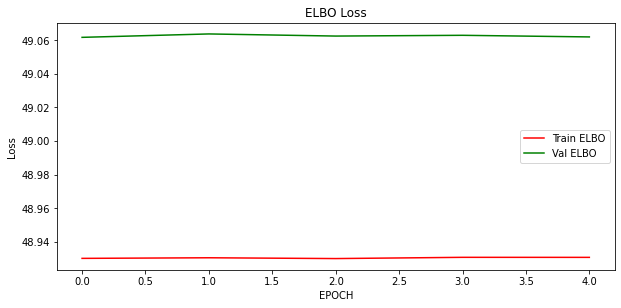

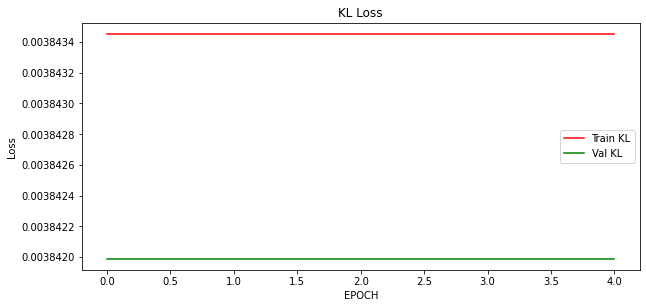

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['test_elbo']))), history_elbo['test_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')
plt.show();

plt.figure(figsize=(10,10))
plt.subplot(212)
plt.plot(list(range(0,len(history_kl['train_kl']))), history_kl['train_kl'], 'r')
plt.plot(list(range(0,len(history_kl['test_kl']))), history_kl['test_kl'],'g')
plt.legend(['Train KL','Val KL'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('KL Loss')

plt.show();

In [ ]:
def predict(model, dataset):
  predictions, elbo_losses, total_losses = [], [],[]
  with torch.no_grad():
    model = model.eval()
    for x in dataset:
        x = x.to(device)
        
        x_hat, z_mu, z_var, rec_mu, rec_var, z_sample = model(x)

        recon_loss= criterion(x_hat, x)
        latent_loss = criterion(x_sample, z_sample)

        KL_loss = -0.5 * torch.mean(1 + z_var - z_mu**2 - torch.exp(z_var))
        KL_latent_loss = -0.5 * torch.mean(1 + rec_var - rec_mu**2 - torch.exp(rec_var))

        elbo_loss = recon_loss + KL_loss
        total_loss = elbo_loss + latent_loss + KL_latent_loss
       

        elbo_losses.append(elbo_loss.item())
        total_losses.append(total_loss.item())
        predictions.append(x_hat.cpu().numpy().flatten())
  return predictions, elbo_losses,kl_losses

In [ ]:
predict_train, elbo_losses,total_losses = predict(model, train_dataset)


In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


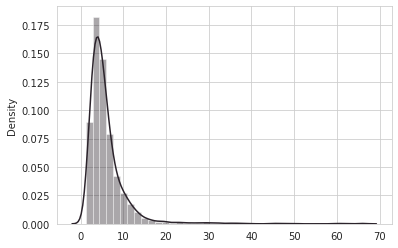

In [ ]:
sns.distplot(total_losses, bins=40, kde=True);

In [ ]:
THRESHOLD = 15

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


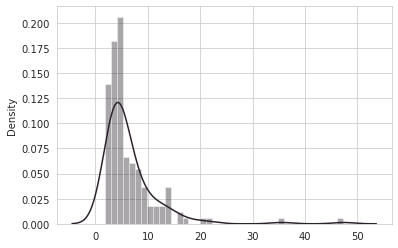

In [ ]:
predict_test, elbo_losses_test,total_losses_test = predict(model,test_normal_dataset)

sns.distplot(total_losses_test, bins=40, kde=True);

In [ ]:
correct = sum(l <= THRESHOLD for l in elbo_losses_test)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 138/145


In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, elbo_losses,kl_losses = predict(model, [data])

  ax.plot(data,'r', label='true')
  ax.plot(predictions[0], 'b',label='reconstructed')
  ax.set_title(f'{title} (Elbo loss: {np.around(elbo_losses[0], 2)})')
  ax.legend()

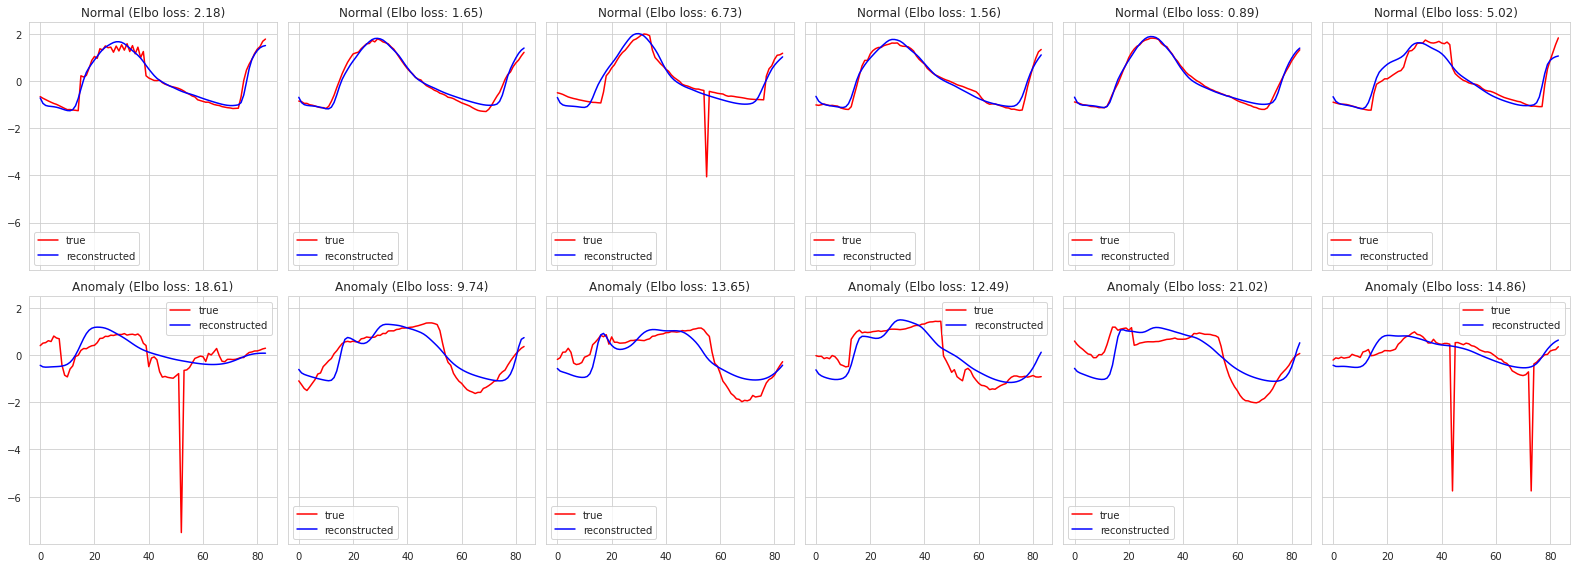

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();